In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import k, m_e, c
import seaborn as sns
sns.set(style="ticks", font_scale=1.25)
from tqdm import tqdm
import sspals

In [3]:
from mc_sspals import initialize, annihilate, convert
from mc_sspals.tools import spectrum
from mc_sspals.laser import Laser, Transition, overlap, frac_excite, t_excite, photoionize
from mc_sspals.plots import bksub
from mc_sspals.velocity import fwhm_w0

In [4]:
# positrons
num = int(1e6)
sigma_x = 1e-3
sigma_t = 2e-9
# converter
eff = 0.25
# Lyman-alpha
lyman_alpha = Transition(wavelength=243.0e-9, linewidth=1.0/(2*np.pi*3.2e-9))
threshold = 0.002
uv = Laser(energy=0.001, wavelength=2.43e-7, bandwidth=85e9, retro=False,
           distance=0.0005, height=0.006, width=0.0025, trigger=15e-9, sigma_t=3e-9)
# detector
kappa = 9e-9
dt = 1e-9
limits = [-1.0E-8, 3.5e-8, 7e-7]

In [5]:
di = initialize(num, sigma_t=sigma_t, sigma_x=sigma_x)
sim_A = convert(di, eff=eff, T=400)
sim_B = convert(di, eff=eff, T=2000)
sims = [sim_A, sim_B]
bk = [spectrum(annihilate(sim), amp=1.0, dt=dt, kappa=kappa)[1] for sim in sims]
f_bk = [sspals.sspals_1D(b, dt, limits=limits)['DF'][0] for b in bk]

In [6]:
# wavelength
wav_vals = np.arange(2.427e-7, 2.433e-7, 5e-12)
fracs_w = []
for sim in sims:
    for wav in tqdm(wav_vals, desc='wavelength', leave=True):
        lz = Laser(energy=0.001, wavelength=wav, bandwidth=85e9, retro=False,
           distance=0.0005, height=0.006, width=0.0025, trigger=15e-9, sigma_t=3e-9)
        fr = frac_excite(sim, lz, lyman_alpha, threshold)
        fracs_w.append(fr)
fracs_w = np.array(fracs_w).reshape((-1, len(wav_vals)))

wavelength: 100%|██████████| 120/120 [00:47<00:00,  2.54it/s]


In [7]:
wav_vals2 = np.arange(2.427e-7, 2.433e-7, 2e-11)
S_w = []
for sim, fb in zip(sims, f_bk):
    for wav in tqdm(wav_vals2, desc='wavelength', leave=True):
        lz = Laser(energy=0.001, wavelength=wav, bandwidth=85e9, retro=False,
           distance=0.0005, height=0.006, width=0.0025, trigger=15e-9, sigma_t=3e-9)
        sg = annihilate(photoionize(sim, lz, lyman_alpha, threshold, prob=1.0))
        spec = spectrum(sg, amp=1.0, dt=dt, kappa=kappa)[1]
        fd = sspals.sspals_1D(spec, dt, limits=limits)['DF'][0]
        S = sspals.signal(fd, 0, fb, 0)[0]
        S_w.append(S)
S_w = np.array(S_w).reshape((len(sims), -1))

wavelength: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


In [8]:
#delay
trig_vals = np.arange(-1e-8, 1.0e-7, 1e-9)
fracs_t = []
for sim in sims:
    for trig in tqdm(trig_vals, desc='delay', leave=True):
        lz = Laser(energy=0.001, wavelength=2.43e-7, bandwidth=85e9, retro=False,
           distance=0.0005, height=0.006, width=0.0025, trigger=trig, sigma_t=3e-9)
        fr = frac_excite(sim, lz, lyman_alpha, threshold)
        fracs_t.append(fr)
fracs_t = np.array(fracs_t).reshape((-1, len(trig_vals)))

delay: 100%|██████████| 110/110 [00:42<00:00,  2.58it/s]


In [9]:
trig_vals2 = np.arange(-1e-8, 1.0e-7, 5e-9)
S_t = []
for sim, fb in zip(sims, f_bk):
    for trig in tqdm(trig_vals2, desc='delay', leave=True):
        lz = Laser(energy=0.001, wavelength=2.43e-7, bandwidth=85e9, retro=False,
           distance=0.0005, height=0.006, width=0.0025, trigger=trig, sigma_t=3e-9)
        sg = annihilate(photoionize(sim, lz, lyman_alpha, threshold, prob=1.0))
        spec = spectrum(sg, amp=1.0, dt=dt, kappa=kappa)[1]
        fd = sspals.sspals_1D(spec, dt, limits=limits)['DF'][0]
        S = sspals.signal(fd, 0, fb, 0)[0]
        S_t.append(S)
S_t = np.array(S_t).reshape((len(sims), -1))

delay: 100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


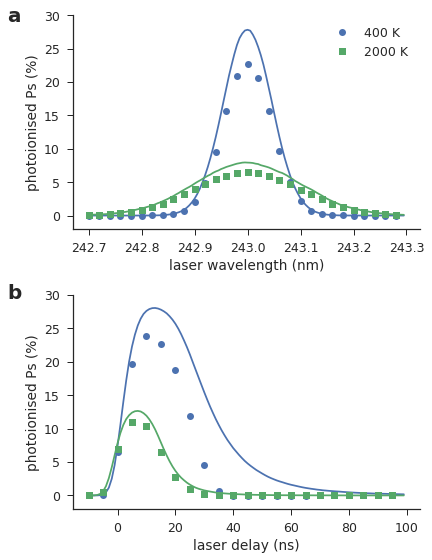

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

colors = ['C0', 'C1']
markers = ['o', 's']
labels = ['400 K', '2000 K']

for (fr, col) in zip(fracs_w, colors):
    ax[0].plot(wav_vals * 1e9, 100 * fr, c=col)

for (S, col, ms, lbl) in zip(S_w, colors, markers, labels):
    ax[0].plot(wav_vals2 * 1e9, S, marker=ms, c=col, ls='', label=lbl)
    
for fr in fracs_t:
    ax[1].plot(trig_vals * 1e9, 100 * fr)

for (S, col, ms, lbl) in zip(S_t, colors, markers, labels):
    ax[1].plot(trig_vals2 * 1e9, S, marker=ms, c=col, ls='', label=lbl)
    
ax[0].legend()
ax[0].set_xlabel('laser wavelength (nm)')
ax[1].set_xlabel('laser delay (ns)')
ax[0].set_ylabel(r'photoionised Ps (%)')
ax[1].set_ylabel(r'photoionised Ps (%)')
ax[0].set_ylim(-2.0, 30)
ax[1].set_ylim(-2.0, 30)

fig.text(-0.006, 0.95, "a", fontsize=20, fontweight='bold')
fig.text(-0.006, 0.470, "b", fontsize=20, fontweight='bold')

# FWHM
#for w, smx in zip([fwhm_w0(T=400, w0=243.0), fwhm_w0(T=2000, w0=243.0)], np.max(fracs_w, axis=1)):
#    ax[0].axvline(243 - w/2)
#    ax[0].axvline(243 + w/2)
#    ax[0].axhline(100*smx/2)

#ax[1].axvline(40)
#ax[1].axhline(7.)

sns.despine(ax=ax[0], trim=False)
sns.despine(ax=ax[1], trim=False)

plt.tight_layout()
#output
plt.savefig("../images/mc_delay_doppler.pdf", bbox_inches='tight', dpi=200)
plt.show()